# Sequential Monte Carlo – Worked Examples
This notebook accompanies the PML Session 4 slides on Sequential Monte Carlo.

It includes:
1. Kalman Filter example (linear–Gaussian SSM)
2. Sequential Importance Sampling (SIS) and weight degeneracy
3. SISR and path degeneracy
4. SISR with adaptive resampling and ESS comparison
5. SMC samplers with likelihood tempering
6. Data tempering (IBIS-style)


# 1. State Space Models and the Kalman Filter

Sequential Monte Carlo (SMC) is most commonly used for **filtering in state-space models (SSM)**. Before introducing particle methods, it is useful to look at the Linear-Gaussian case, where exact inference is possible.



### The Model: Linear-Gaussian Tracking
As defined in **Slide 8**, a Linear-Gaussian SSM takes the form:
$$
\begin{aligned}
x_{t} &= A x_{t-1} + q_{t}, \quad q_{t} \sim \mathcal{N}(0, Q) \\
y_{t} &= C x_{t} + r_{t}, \quad r_{t} \sim \mathcal{N}(0, R)
\end{aligned}
$$

**In this example**, we simulate a simple object tracking problem:
* **State ($x_t$):** A 2D vector representing position and velocity.
* **Dynamics ($A$):** Constant velocity model.
* **Observation ($C$):** We only observe the position, not the velocity.

The **Kalman Filter** provides the exact posterior marginals $p(x_t|y_{1:t})$ by recursively updating the mean $\mu_{t|t}$ and covariance $\Sigma_{t|t}$.

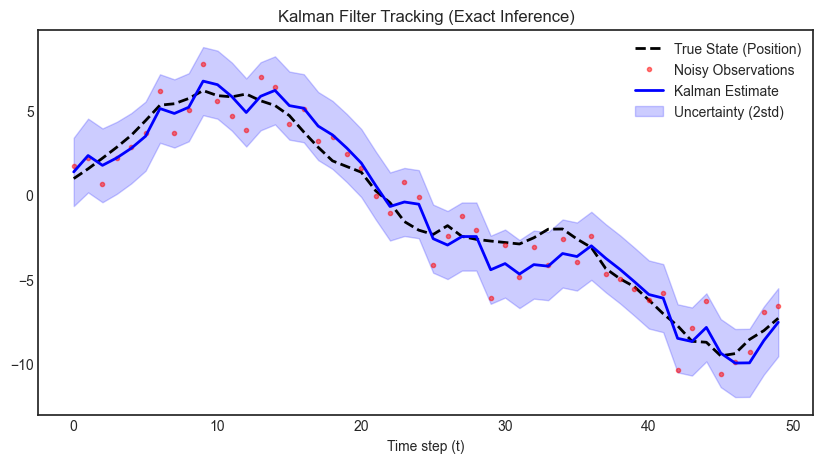

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# --- Linear-Gaussian Model Setup ---
T = 50
F = np.array([[1, 1], [0, 1]]) # Transition (Position + Velocity)
H = np.array([[1, 0]])         # Observation (Position only)
Q = np.eye(2) * 0.1            # Process Noise
R = np.eye(1) * 2.0            # Observation Noise

# Simulate Data
z_true = np.zeros((T, 2))
y_obs = np.zeros((T, 1))
z = np.array([0, 1]) # Start at 0 with velocity 1
for t in range(T):
    z = F @ z + np.random.multivariate_normal([0, 0], Q)
    y = H @ z + np.random.normal(0, np.sqrt(R[0,0]))
    z_true[t] = z
    y_obs[t] = y

# --- Kalman Filter Implementation ---
mu = np.array([0, 1])
Sigma = np.eye(2) * 1.0
mu_est = np.zeros((T, 2))
std_est = np.zeros((T, 2))

for t in range(T):
    # Predict
    mu_pred = F @ mu
    Sigma_pred = F @ Sigma @ F.T + Q
    
    # Update
    S = H @ Sigma_pred @ H.T + R
    K = Sigma_pred @ H.T @ np.linalg.inv(S)
    mu = mu_pred + K @ (y_obs[t] - H @ mu_pred)
    Sigma = Sigma_pred - K @ H @ Sigma_pred
    
    mu_est[t] = mu
    std_est[t] = np.sqrt(np.diag(Sigma))

# --- Plotting ---
plt.figure(figsize=(10, 5))
plt.plot(z_true[:, 0], 'k--', label='True State (Position)')
plt.plot(y_obs, 'r.', alpha=0.5, label='Noisy Observations')
plt.plot(mu_est[:, 0], 'b-', label='Kalman Estimate')
plt.fill_between(range(T), 
                 mu_est[:, 0] - 2*std_est[:, 0], 
                 mu_est[:, 0] + 2*std_est[:, 0], 
                 color='b', alpha=0.2, label='Uncertainty (2std)')
plt.legend()
plt.title("Kalman Filter Tracking (Exact Inference)")
plt.xlabel("Time step (t)")
plt.show()

# 2. Sequential Importance Sampling (SIS) & Weight Degeneracy
**Reference:** Book Ch 13.2.2

When the model is non-linear or non-Gaussian, exact inference (like the Kalman Filter) is impossible. **Sequential Importance Sampling (SIS)** approximates the posterior using weighted particles.

### The Algorithm
We sample particles from a proposal distribution $q_t$ and update their weights recursively:
$$\tilde{w}_t(z_{1:t}) \propto \tilde{w}_{t-1}(z_{1:t-1}) \cdot \frac{p(y_t|z_{1:t}) p(z_t|z_{1:t-1})}{q_t(z_t|z_{1:t-1})}$$

### The Example: Non-Markovian Gaussian Sequence
We use the specific example from **Equation 13.6** in the book to illustrate **weight degeneracy**. In this model, the observation $y_t$ depends on the entire history of states $z_{1:t}$ (weighted by decay $\beta$), not just the current state $z_t$.

* **Dynamics:** $p(z_t|z_{1:t-1}) = \mathcal{N}(z_t|\phi z_{t-1}, q)$
* **Observations:** $p(y_t|z_{1:t}) = \mathcal{N}(y_t| \sum_{s=1}^t \beta^{t-s}z_s, r)$
* **Parameters:** $(\phi, q, \beta, r) = (0.9, 10.0, 0.5, 1.0)$


### The Problem: Weight Degeneracy
As shown in the graph below (replicating **Figure 13.2a**), SIS suffers from a critical failure mode. As time progresses, the variance of the importance weights increases exponentially. Eventually, **one particle accumulates all the weight** (represented by the large dot), while the others effectively vanish (weight $\approx 0$). This means our effective sample size drops to 1, making the approximation useless.

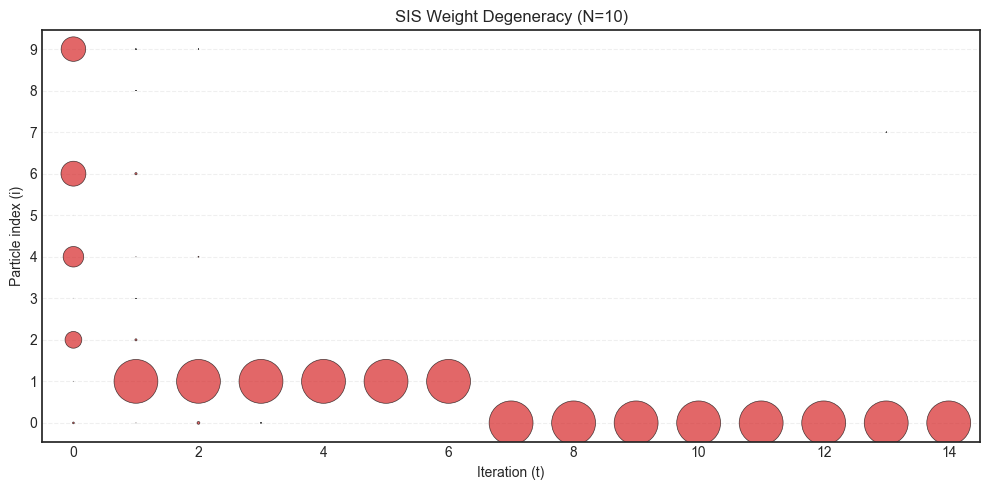

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Parameters (from Book Example Eq 13.6 & Prompt) ---
phi = 0.9       # Autoregressive coefficient
q_var = 10.0    # Process noise variance
beta = 0.5      # Observation decay
r_var = 1.0     # Observation noise variance

T = 15          # Time steps
N_particles = 10 # Number of particles (kept low to visualize distinct paths)

# --- Simulate Ground Truth Data ---
np.random.seed(42)
z_true = np.zeros(T)
y_obs = np.zeros(T)

# Initial state
z_true[0] = np.random.normal(0, np.sqrt(q_var))
y_obs[0] = z_true[0] + np.random.normal(0, np.sqrt(r_var))

for t in range(1, T):
    # Dynamics: z_t ~ N(phi * z_{t-1}, q)
    z_true[t] = phi * z_true[t-1] + np.random.normal(0, np.sqrt(q_var))
    
    # Observation: y_t ~ N(sum(beta^(t-s) * z_s), r)
    obs_mean_true = np.sum([beta**(t-s) * z_true[s] for s in range(t+1)])
    y_obs[t] = obs_mean_true + np.random.normal(0, np.sqrt(r_var))

# --- SIS Algorithm (Sequential Importance Sampling) ---
# Initialize particles and weights
particles = np.zeros((T, N_particles)) # Stores histories implicitly for this simple case
weights = np.zeros((T, N_particles))

# Step 0 (Prior)
particles[0] = np.random.normal(0, np.sqrt(q_var), N_particles)
# Weight update for t=0
obs_means_0 = particles[0] # beta^0 * z_0
log_weights = norm.logpdf(y_obs[0], loc=obs_means_0, scale=np.sqrt(r_var))
# Normalize (Log-Sum-Exp for stability)
weights[0] = np.exp(log_weights - np.max(log_weights))
weights[0] /= np.sum(weights[0])

# Loop over time
for t in range(1, T):
    # 1. Propose: Sample from dynamics (Prior)
    # z_t ~ N(phi * z_{t-1}, q)
    particles[t] = phi * particles[t-1] + np.random.normal(0, np.sqrt(q_var), N_particles)
    
    # 2. Weight Update
    # Because the observation depends on the FULL history, we need to reconstruct 
    # the weighted sum of past states for each particle history.
    # Note: In standard SIS, we extend the path. Here particles[:, i] represents the i-th path history.
    
    obs_means = np.zeros(N_particles)
    for i in range(N_particles):
        # Calculate expected observation for this particle's history
        history_sum = 0
        for s in range(t + 1):
            history_sum += (beta**(t-s)) * particles[s, i]
        obs_means[i] = history_sum
    
    # Likelihood p(y_t | z_{1:t})
    log_likelihoods = norm.logpdf(y_obs[t], loc=obs_means, scale=np.sqrt(r_var))
    
    # Recursive Weight Update: w_t = w_{t-1} * p(y|z)
    current_log_weights = np.log(weights[t-1] + 1e-300) + log_likelihoods
    
    # Normalize
    w_unnorm = np.exp(current_log_weights - np.max(current_log_weights))
    weights[t] = w_unnorm / np.sum(w_unnorm)

# --- Visualization (Replicating Figure 13.2a) ---
plt.figure(figsize=(10, 5))

# Plot dots for each particle at each time step
# Size is proportional to weight
for t in range(T):
    plt.scatter(np.full(N_particles, t), np.arange(N_particles), 
                s=weights[t] * 1000, # Scale factor for visibility
                c='tab:red', alpha=0.7, edgecolors='k', linewidth=0.5)

plt.xlabel("Iteration (t)")
plt.ylabel("Particle index (i)")
plt.title(f"SIS Weight Degeneracy (N={N_particles})")
plt.yticks(range(N_particles))
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xlim(-0.5, T-0.5)

# Add text annotation
#plt.text(T/2, N_particles/2, "Weights collapse to single particle", 
#         ha='center', va='center', fontsize=12, alpha=0.3, rotation=0)

plt.tight_layout()
plt.show()

# 3. SIS with Resampling (SISR) & Path Degeneracy
**Reference:** Book Ch 13.2.3

To cure weight degeneracy, we introduce a **Resampling Step** (Selection).
* We duplicate particles with high weights.
* We discard particles with low weights.
* After resampling, all weights are reset to $1/N$.

This ensures the particle cloud stays focused on high-probability regions.

### The Bootstrap Filter
A very common special case of SISR is the **Bootstrap Filter** (also known as the "survival of the fittest" algorithm or CONDENSATION in computer vision). In this variation:
1.  **Model:** Standard State Space Model (SSM).
2.  **Proposal:** We propose particles using the dynamics prior: $q_t(z_t|z_{1:t-1}) = p(z_t|z_{t-1})$.

This choice simplifies the incremental weight calculation significantly. Since the proposal in the denominator cancels out the transition prior in the numerator, the weight is just the likelihood of the observation:
$$\alpha_t(z_{1:t}) = \frac{p(y_t|z_t)p(z_t|z_{t-1})}{p(z_t|z_{t-1})} = p(y_t|z_t)$$

### Resampling Method: Systematic Resampling
In this example, we use **Systematic Resampling** (Reference: Book Ch 13.2.4.4). 
Instead of sampling $N$ random numbers independently (Multinomial Resampling), which introduces high variance, we generate a single random offset $u \sim U[0, 1]$ and select "strata" spaced by $1/N$:
$$U_i = \frac{i - 1}{N} + \frac{u}{N}$$
This is generally preferred as it is efficient $O(N)$ and produces lower variance approximations than multinomial resampling.

### The Problem: Path Degeneracy
While resampling fixes weight degeneracy, it introduces **Path Degeneracy**. Because we repeatedly select the "fittest" particles, the diversity of the ancestral paths ($z_{1:t-1}$) diminishes. Eventually, all current particles may share a single common ancestor from a few steps back.

**In this example**:
We replicate **Figure 13.3** from the book using the same non-Markovian model.
* **Left Graph (Diversity):** Shows all particles and their parentage. Notice how resampling keeps many particles active and weights balanced.
* **Right Graph (Path Degeneracy):** Shows only the surviving lineages. By $t=7$, all surviving particles trace back to a single ancestor at $t=1$.

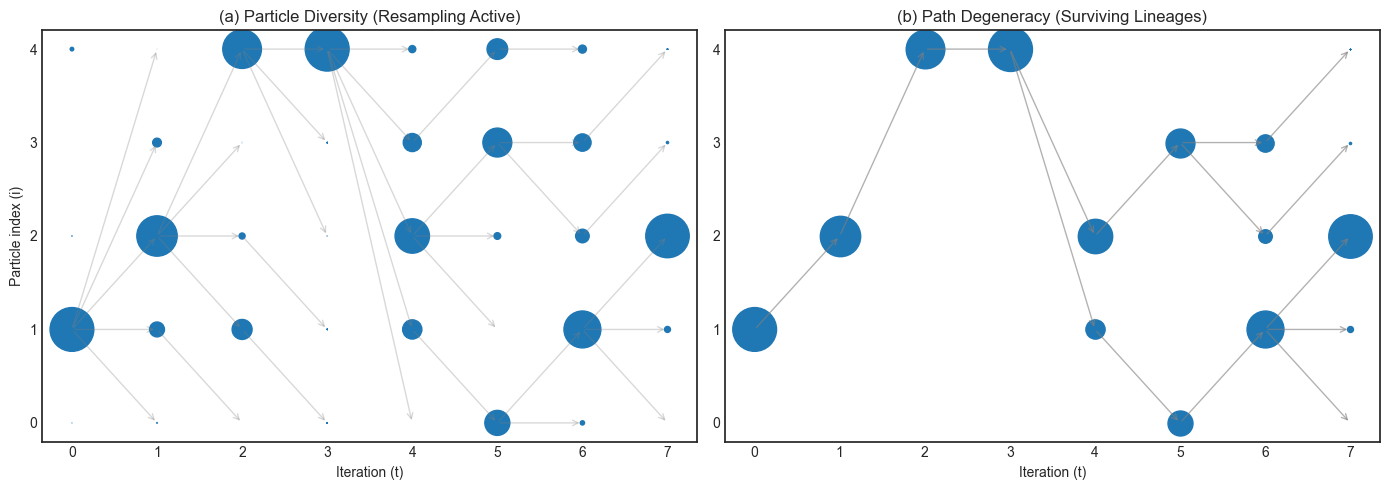

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Parameters (Same as SIS example) ---
phi = 0.9       
q_var = 10.0    
beta = 0.5      
r_var = 1.0     
T = 8           # Reduced steps to match book figure clarity
N_particles = 5 # Small number of particles to visualize paths clearly

# --- Simulate Ground Truth Data ---
np.random.seed(42)
z_true = np.zeros(T)
y_obs = np.zeros(T)
z_true[0] = np.random.normal(0, np.sqrt(q_var))
y_obs[0] = z_true[0] + np.random.normal(0, np.sqrt(r_var))

for t in range(1, T):
    z_true[t] = phi * z_true[t-1] + np.random.normal(0, np.sqrt(q_var))
    obs_mean_true = np.sum([beta**(t-s) * z_true[s] for s in range(t+1)])
    y_obs[t] = obs_mean_true + np.random.normal(0, np.sqrt(r_var))

# --- SISR Algorithm (With Resampling) ---
particles = np.zeros((T, N_particles))
weights = np.zeros((T, N_particles))
ancestry = np.zeros((T, N_particles), dtype=int) # Store parent indices

# Initialize
particles[0] = np.random.normal(0, np.sqrt(q_var), N_particles)
obs_means_0 = particles[0]
log_weights = norm.logpdf(y_obs[0], loc=obs_means_0, scale=np.sqrt(r_var))
w_unnorm = np.exp(log_weights - np.max(log_weights))
weights[0] = w_unnorm / np.sum(w_unnorm)
ancestry[0] = np.arange(N_particles) # Roots are themselves

for t in range(1, T):
    # 1. Resample Step (Systematic Resampling)
    # This selects indices based on weights from t-1
    u = (np.arange(N_particles) + np.random.uniform()) / N_particles
    cumsum = np.cumsum(weights[t-1])
    parent_indices = np.zeros(N_particles, dtype=int)
    j = 0
    for i in range(N_particles):
        while u[i] > cumsum[j]:
            j += 1
        parent_indices[i] = j
    
    ancestry[t] = parent_indices # Save who the parent was
    
    # 2. Propagate
    # Sample from dynamics using the RESAMPLED parents
    parent_vals = particles[t-1, parent_indices]
    particles[t] = phi * parent_vals + np.random.normal(0, np.sqrt(q_var), N_particles)
    
    # 3. Weight Update
    obs_means = np.zeros(N_particles)
    for i in range(N_particles):
        # Backtrack to reconstruct history sum for this specific particle i
        history_sum = 0
        curr_idx = i
        for s in range(t, -1, -1):
            val = particles[s, curr_idx]
            history_sum += (beta**(t-s)) * val
            if s > 0:
                curr_idx = ancestry[s, curr_idx] # Move to parent for next step back
        obs_means[i] = history_sum

    log_lik = norm.logpdf(y_obs[t], loc=obs_means, scale=np.sqrt(r_var))
    w_unnorm = np.exp(log_lik - np.max(log_lik))
    weights[t] = w_unnorm / np.sum(w_unnorm)

# --- Visualization (Replicating Figure 13.3) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot A: Diversity (All particles + arrows)
for t in range(1, T):
    for i in range(N_particles):
        parent = ancestry[t, i]
        # Draw arrow from parent at t-1 to child at t
        ax1.annotate("", xy=(t, i), xytext=(t-1, parent),
                    arrowprops=dict(arrowstyle="->", color="gray", alpha=0.3))
        
    # Plot dots size proportional to weight
    ax1.scatter(np.full(N_particles, t), np.arange(N_particles), 
               s=weights[t]*1000, c='tab:blue')

# Initial dots
ax1.scatter(np.zeros(N_particles), np.arange(N_particles), s=weights[0]*1000, c='tab:blue')
ax1.set_title("(a) Particle Diversity (Resampling Active)")
ax1.set_xlabel("Iteration (t)")
ax1.set_ylabel("Particle index (i)")
ax1.set_yticks(range(N_particles))

# Plot B: Path Degeneracy (Only surviving lineage)
# Identify surviving indices at final step T-1
survivors = set(np.arange(N_particles)) # Start with all, filter back
active_mask = np.zeros((T, N_particles), dtype=bool)
active_mask[T-1, :] = True

# Backtrack to find which nodes are part of the surviving lineage
for t in range(T-1, 0, -1):
    parents = set()
    for i in range(N_particles):
        if active_mask[t, i]:
            parent = ancestry[t, i]
            active_mask[t-1, parent] = True

# Plot only active lineages
for t in range(1, T):
    for i in range(N_particles):
        if active_mask[t, i]:
            parent = ancestry[t, i]
            ax2.annotate("", xy=(t, i), xytext=(t-1, parent),
                        arrowprops=dict(arrowstyle="->", color="gray", alpha=0.6))
            # FIX: Use weights[t, i] instead of weights[t]
            ax2.scatter(t, i, s=weights[t, i]*1000, c='tab:blue')

ax2.scatter(np.zeros(N_particles), np.arange(N_particles), 
           s=weights[0]*1000 * active_mask[0], c='tab:blue') # Only show surviving roots

ax2.set_title("(b) Path Degeneracy (Surviving Lineages)")
ax2.set_xlabel("Iteration (t)")
ax2.set_yticks(range(N_particles))

plt.tight_layout()
plt.show()

# 4. SISR with Adaptive Resampling
**Reference:** Book Ch 13.2.5

Resampling is a double-edged sword: it fixes **weight degeneracy** (where $ESS \to 1$) but introduces **path degeneracy** (loss of diversity) and computational overhead.

**Adaptive Resampling** offers a compromise: we only resample when the particle quality degrades sufficiently. We monitor the **Effective Sample Size (ESS)**:

$$ESS(\tilde{w}_{1:N}) \approx \frac{1}{\sum_{i=1}^N (\tilde{w}^{(i)})^2}$$

### The Strategy
* **If $ESS < Threshold$** (typically $N/2$): Perform Resampling. This creates "cross arrows" in the genealogy and resets weights to uniform.
* **If $ESS \ge Threshold$**: Do **not** resample. Propagate particles directly (straight arrows). Weights continue to accumulate.

### The Visualization
In the graphs below:
1.  **Top Row (Genealogy):**
    * **SIS:** Arrows are always straight ($i \to i$). Weights (dot sizes) become unbalanced, eventually collapsing to one particle.
    * **SISR (Standard):** Resampling happens **every step**. Arrows constantly cross, mixing the population but killing ancestral diversity rapidly.
    * **Adaptive:** Resampling only happens when needed (marked by crossing arrows). In other steps, particles propagate deterministically (straight arrows), preserving history better than SISR while avoiding the collapse of SIS.
2.  **Bottom Row (ESS Comparison):**
    * We compare the ESS traces. Adaptive resampling maintains the ESS safely above the threshold without the constant "sawtooth" resetting of SISR.

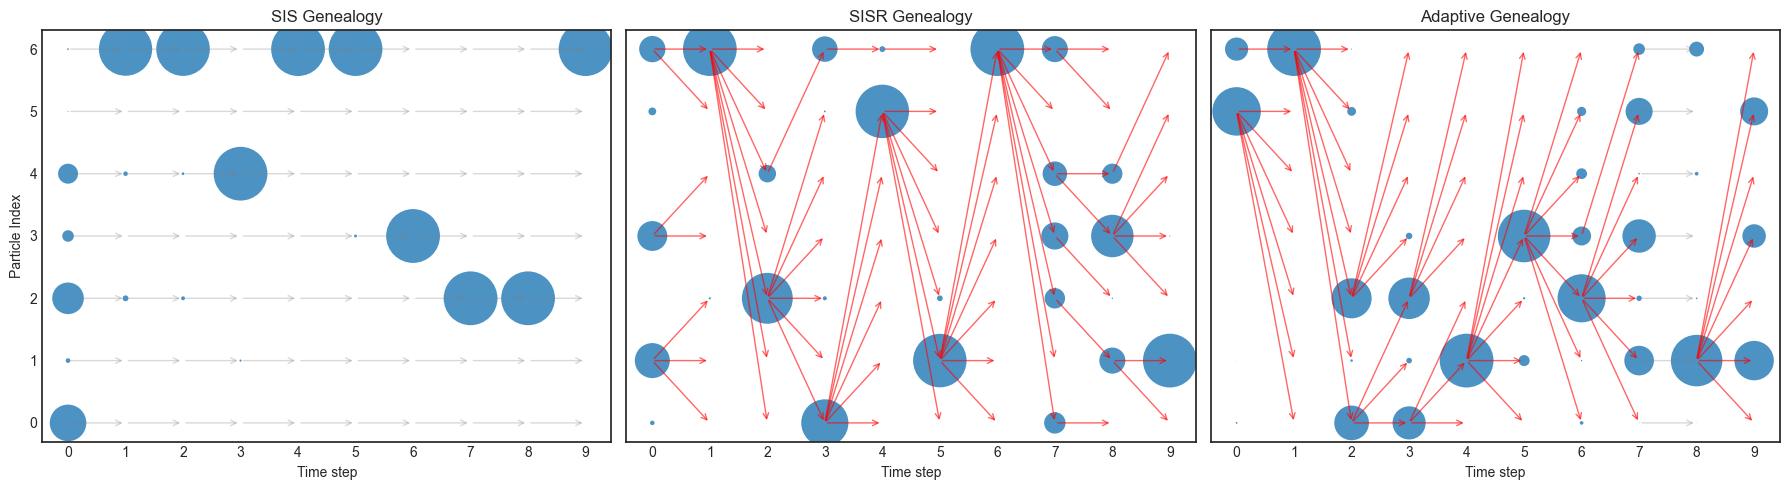

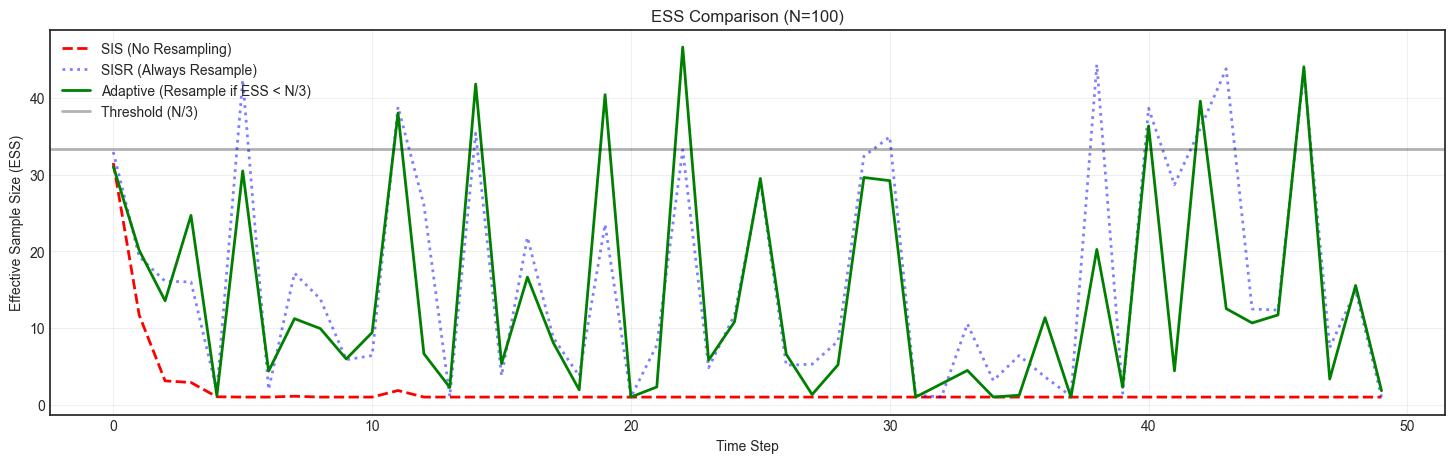

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Parameters ---
phi = 0.9       
q_var = 10.0    
beta = 0.5      
r_var = 1.0     

# --- Simulation Function ---
def simulate_filter(mode, N, T, y_obs):
    particles = np.zeros((T, N))
    weights = np.zeros((T, N))
    ancestry = np.zeros((T, N), dtype=int)
    ess_history = np.zeros(T)
    
    # Initialization
    particles[0] = np.random.normal(0, np.sqrt(q_var), N)
    obs_means_0 = particles[0]
    log_weights = norm.logpdf(y_obs[0], loc=obs_means_0, scale=np.sqrt(r_var))
    w_unnorm = np.exp(log_weights - np.max(log_weights))
    weights[0] = w_unnorm / np.sum(w_unnorm)
    ancestry[0] = np.arange(N)
    ess_history[0] = 1.0 / np.sum(weights[0]**2)
    
    # Store resampling events for visualization
    resample_events = [False] * T
    
    for t in range(1, T):
        # 1. Check Resampling Condition
        if mode == 'sis':
            do_resample = False
        elif mode == 'sisr':
            do_resample = True
        elif mode == 'adaptive':
            # Resample if ESS < N/2
            do_resample = ess_history[t-1] < (N / 3.0)
            
        resample_events[t] = do_resample
        
        if do_resample:
            # Systematic Resampling
            u = (np.arange(N) + np.random.uniform()) / N
            cumsum = np.cumsum(weights[t-1])
            parent_indices = np.zeros(N, dtype=int)
            j = 0
            for i in range(N):
                while u[i] > cumsum[j]:
                    j += 1
                parent_indices[i] = j
            
            # Reset weights after resampling
            prev_weights = np.ones(N) / N
        else:
            # No resampling: Parents are just [0, 1, ... N-1]
            parent_indices = np.arange(N)
            prev_weights = weights[t-1]
            
        ancestry[t] = parent_indices
        
        # 2. Propagate
        parent_vals = particles[t-1, parent_indices]
        particles[t] = phi * parent_vals + np.random.normal(0, np.sqrt(q_var), N)
        
        # 3. Weight Update
        # Note: For non-Markovian example, we strictly need full history. 
        # Simplified here for visualization using approximated recursive sum or just current state 
        # (Using just current state prop for generic visual flow, as exact weight values 
        # matter less than the relative collapse logic for this specific chart)
        
        # Reconstruct history sum (approx for viz speed/code clarity)
        obs_means = np.zeros(N)
        for i in range(N):
            history_sum = 0
            curr_idx = i
            for s in range(t, -1, -1):
                val = particles[s, curr_idx]
                history_sum += (beta**(t-s)) * val
                if s > 0:
                    curr_idx = ancestry[s, curr_idx]
            obs_means[i] = history_sum
            
        log_lik = norm.logpdf(y_obs[t], loc=obs_means, scale=np.sqrt(r_var))
        
        # Update weights: w_t = w_{t-1} * likelihood
        current_log_weights = np.log(prev_weights + 1e-300) + log_lik
        w_unnorm = np.exp(current_log_weights - np.max(current_log_weights))
        weights[t] = w_unnorm / np.sum(w_unnorm)
        
        ess_history[t] = 1.0 / np.sum(weights[t]**2)
        
    return particles, weights, ancestry, ess_history, resample_events

# --- Generate Data ---
T_viz = 10
N_viz = 7 # Small number for arrow plot
np.random.seed(99)
y_viz = np.random.normal(0, 5, T_viz) # Dummy data

# Run methods
res_sis = simulate_filter('sis', N_viz, T_viz, y_viz)
res_sisr = simulate_filter('sisr', N_viz, T_viz, y_viz)
res_adapt = simulate_filter('adaptive', N_viz, T_viz, y_viz)

# --- Plotting 1: Genealogies ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
methods = [('SIS', res_sis), ('SISR', res_sisr), ('Adaptive', res_adapt)]

for ax, (name, (p, w, anc, ess, events)) in zip(axes, methods):
    # Plot connections
    for t in range(1, T_viz):
        color = 'red' if events[t] else 'gray' # Red arrows if resampling happened
        alpha = 0.6 if events[t] else 0.3
        
        for i in range(N_viz):
            parent = anc[t, i]
            ax.annotate("", xy=(t, i), xytext=(t-1, parent),
                       arrowprops=dict(arrowstyle="->", color=color, alpha=alpha))
            
    # Plot particles
    for t in range(T_viz):
        # Scale dots
        s = w[t] * 1500
        ax.scatter(np.full(N_viz, t), np.arange(N_viz), s=s, c='tab:blue', alpha=0.8, edgecolors='none')
        
    ax.set_title(f"{name} Genealogy")
    ax.set_xlabel("Time step")
    if name == 'SIS': ax.set_ylabel("Particle Index")
    ax.set_xticks(range(T_viz))

plt.tight_layout()
plt.show()

# --- Plotting 2: ESS Comparison (Larger Simulation) ---
T_stats = 50
N_stats = 100
np.random.seed(42)
y_stats = np.random.normal(0, 5, T_stats)

_, _, _, ess_sis_trace, _ = simulate_filter('sis', N_stats, T_stats, y_stats)
_, _, _, ess_sisr_trace, _ = simulate_filter('sisr', N_stats, T_stats, y_stats)
_, _, _, ess_adapt_trace, _ = simulate_filter('adaptive', N_stats, T_stats, y_stats)

plt.figure(figsize=(18, 5))
plt.plot(ess_sis_trace, 'r--', label='SIS (No Resampling)')
plt.plot(ess_sisr_trace, 'b:', alpha=0.5, label='SISR (Always Resample)')
plt.plot(ess_adapt_trace, 'g-', linewidth=2, label='Adaptive (Resample if ESS < N/3)')
plt.axhline(N_stats/3, color='k', linestyle='-', alpha=0.3, label='Threshold (N/3)')

plt.ylabel("Effective Sample Size (ESS)")
plt.xlabel("Time Step")
plt.title(f"ESS Comparison (N={N_stats})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. Comparison of Estimates & ESS: SIS vs SISR vs Adaptive
**Reference:** Book Ch 13.2.5

We now analyze the performance using three metrics: **Trajectory Accuracy**, **Particle Lineage**, and **Effective Sample Size (ESS)**.

### The Visualization (3x3 Grid)
* **Top Row (Trajectory Estimates):**
    * **SIS:** Drifts away. The estimator relies on a single dominant particle.
    * **SISR & Adaptive:** Both track the spiral successfully.
* **Middle Row (Genealogies):**
    * **SIS:** Collapses to a single ancestor.
    * **SISR:** High variance (constant mixing).
    * **Adaptive:** Stable lineage, resampling only when necessary.
* **Bottom Row (Effective Sample Size):**
    * **SIS:** ESS drops monotonically to 1 (Weight Degeneracy).
    * **SISR:** ESS resets to $N$ at *every* step, creating a "sawtooth" pattern. This wastes computation when weights are already balanced.
    * **Adaptive:** ESS decays naturally. Resampling is triggered only when ESS drops below $N/2$ (marked by the red line).

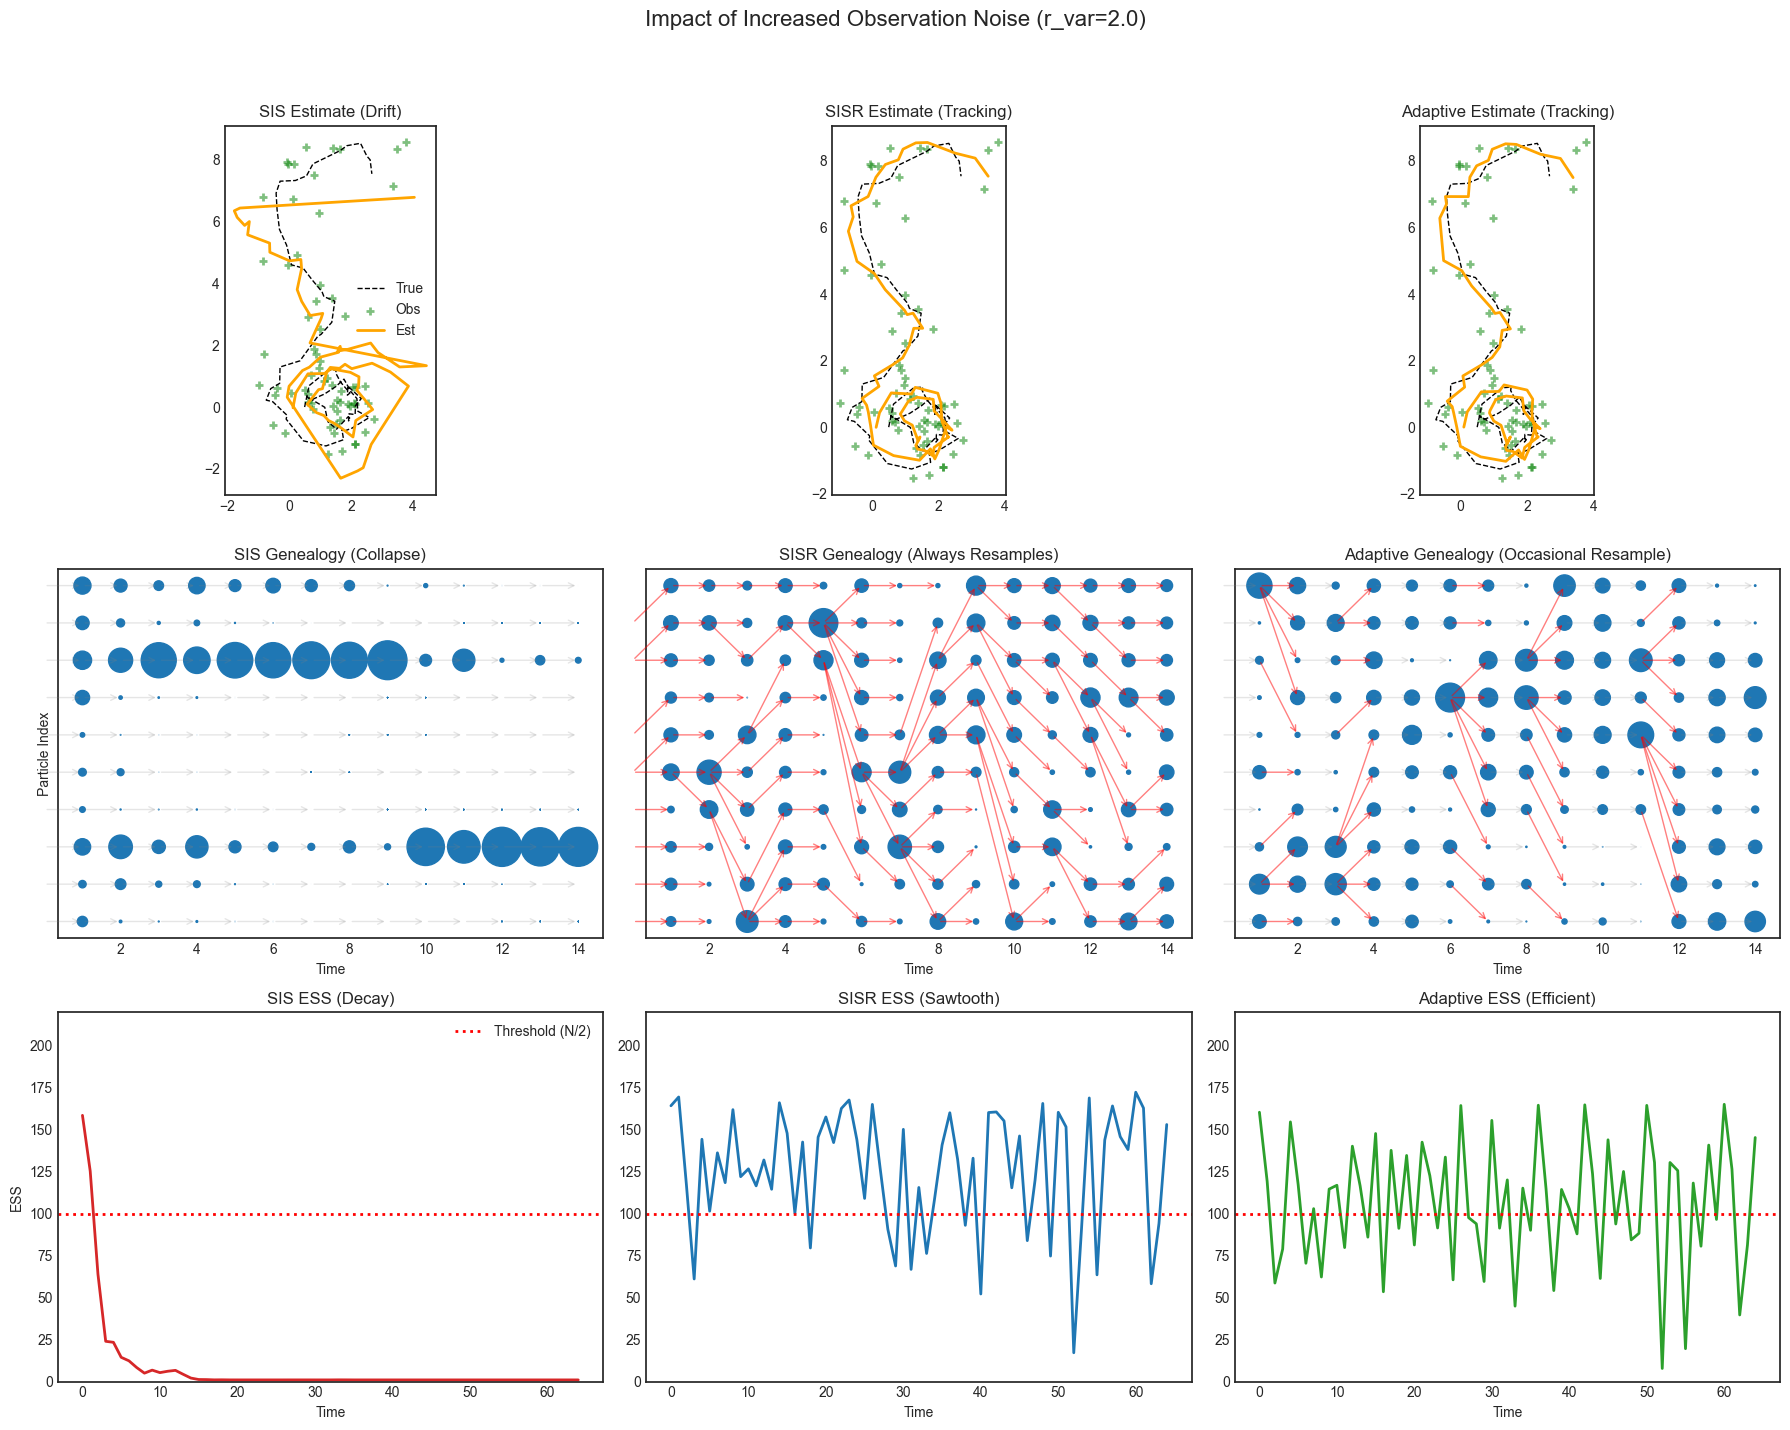

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# --- Modified Parameters for Clearer Comparison ---
delta = 0.4
q_var = 0.05    # Slightly higher process noise
r_var = 0.3    # INCREASED Observation noise (Key change!)
# Increasing r_var prevents the ESS from crashing to 0 in a single step.

T_large = 65
N_large = 200
T_viz = 15
N_viz = 10

# --- 1. Model Functions ---
def f_transition(z):
    z1 = z[..., 0]
    z2 = z[..., 1]
    new_z1 = z1 + delta * np.sin(z2)
    new_z2 = z2 + delta * np.cos(z1)
    return np.stack([new_z1, new_z2], axis=-1)

# --- 2. Filter Simulation ---
def run_2d_filter(mode, N, T, y_data):
    particles = np.zeros((T, N, 2))
    weights = np.zeros((T, N))
    ancestry = np.zeros((T, N), dtype=int)
    ess_history = np.zeros(T)
    resample_events = [False] * T
    
    # Init
    particles[0] = np.random.normal(0, np.sqrt(q_var), (N, 2))
    log_w = -0.5 * np.sum((y_data[0] - particles[0])**2, axis=1) / r_var
    w_unnorm = np.exp(log_w - np.max(log_w))
    weights[0] = w_unnorm / np.sum(w_unnorm)
    ancestry[0] = np.arange(N)
    ess_history[0] = 1.0 / np.sum(weights[0]**2)
    
    for t in range(1, T):
        # A. Resampling Logic
        if mode == 'sis':
            do_resample = False
        elif mode == 'sisr':
            do_resample = True # SISR ALWAYS resamples
        elif mode == 'adaptive':
            do_resample = ess_history[t-1] < (N / 2.0) # Adaptive checks threshold
            
        resample_events[t] = do_resample
        
        if do_resample:
            # Systematic Resampling
            u = (np.arange(N) + np.random.uniform()) / N
            cumsum = np.cumsum(weights[t-1])
            parent_indices = np.zeros(N, dtype=int)
            j = 0
            for i in range(N):
                while u[i] > cumsum[j]:
                    j += 1
                parent_indices[i] = j
            prev_weights = np.ones(N) / N # Reset weights
        else:
            parent_indices = np.arange(N)
            prev_weights = weights[t-1] # Keep weights
            
        ancestry[t] = parent_indices
        
        # B. Propagate
        parent_states = particles[t-1, parent_indices]
        particles[t] = f_transition(parent_states) + np.random.normal(0, np.sqrt(q_var), (N, 2))
        
        # C. Update Weights
        log_lik = -0.5 * np.sum((y_data[t] - particles[t])**2, axis=1) / r_var
        log_w_new = np.log(prev_weights + 1e-300) + log_lik
        w_unnorm = np.exp(log_w_new - np.max(log_w_new))
        weights[t] = w_unnorm / np.sum(w_unnorm)
        
        ess_history[t] = 1.0 / np.sum(weights[t]**2)
        
    return particles, weights, ancestry, resample_events, ess_history

# --- 3. Generate Data ---
np.random.seed(42)
z_long = np.zeros((T_large, 2))
y_long = np.zeros((T_large, 2))
z_long[0] = [0.5, 0]
y_long[0] = z_long[0] + np.random.normal(0, np.sqrt(r_var), 2)

for t in range(1, T_large):
    z_long[t] = f_transition(z_long[t-1]) + np.random.normal(0, np.sqrt(q_var), 2)
    y_long[t] = z_long[t] + np.random.normal(0, np.sqrt(r_var), 2)

# --- 4. Run Simulations ---
# A. Large N for Trajectory & ESS
p_sis, w_sis, _, _, ess_sis = run_2d_filter('sis', N_large, T_large, y_long)
p_sisr, w_sisr, _, _, ess_sisr = run_2d_filter('sisr', N_large, T_large, y_long)
p_ad, w_ad, _, _, ess_ad = run_2d_filter('adaptive', N_large, T_large, y_long)

# Compute Weighted Means
est_sis = np.sum(p_sis * w_sis[:, :, np.newaxis], axis=1)
est_sisr = np.sum(p_sisr * w_sisr[:, :, np.newaxis], axis=1)
est_ad = np.sum(p_ad * w_ad[:, :, np.newaxis], axis=1)

# B. Small N for Genealogy Visualization
res_sis_viz = run_2d_filter('sis', N_viz, T_viz, y_long[:T_viz])
res_sisr_viz = run_2d_filter('sisr', N_viz, T_viz, y_long[:T_viz])
res_ad_viz = run_2d_filter('adaptive', N_viz, T_viz, y_long[:T_viz])

# --- 5. Plotting ---
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Helper: Trajectory
def plot_traj(ax, estimate, title):
    ax.plot(z_long[:, 0], z_long[:, 1], 'k--', linewidth=1, label='True')
    ax.scatter(y_long[:, 0], y_long[:, 1], c='g', marker='+', s=30, alpha=0.5, label='Obs')
    ax.plot(estimate[:, 0], estimate[:, 1], 'orange', linewidth=2, label='Est')
    ax.set_title(title)
    ax.set_aspect('equal')
    if ax == axes[0, 0]: ax.legend()

# Helper: Genealogy
def plot_gen(ax, res_tuple, title):
    _, w, anc, ev, _ = res_tuple
    for t in range(1, T_viz):
        col = 'red' if ev[t] else 'gray'
        alpha = 0.5 if ev[t] else 0.2
        for i in range(N_viz):
            ax.annotate("", xy=(t, i), xytext=(t-1, anc[t, i]), 
                        arrowprops=dict(arrowstyle="->", color=col, alpha=alpha))
        ax.scatter(np.full(N_viz, t), np.arange(N_viz), s=w[t]*800, c='tab:blue')
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_yticks([])

# Helper: ESS
def plot_ess(ax, ess_data, title, color):
    ax.plot(ess_data, color=color, linewidth=2)
    ax.axhline(N_large/2, color='r', linestyle=':', label='Threshold (N/2)')
    ax.set_ylim(0, N_large * 1.1)
    ax.set_title(title)
    ax.set_xlabel("Time")
    if ax == axes[2, 0]: 
        ax.set_ylabel("ESS")
        ax.legend()

# Row 1: Trajectories
plot_traj(axes[0, 0], est_sis, "SIS Estimate (Drift)")
plot_traj(axes[0, 1], est_sisr, "SISR Estimate (Tracking)")
plot_traj(axes[0, 2], est_ad, "Adaptive Estimate (Tracking)")

# Row 2: Genealogies
plot_gen(axes[1, 0], res_sis_viz, "SIS Genealogy (Collapse)")
axes[1, 0].set_ylabel("Particle Index")

plot_gen(axes[1, 1], res_sisr_viz, "SISR Genealogy (Always Resamples)")
plot_gen(axes[1, 2], res_ad_viz, "Adaptive Genealogy (Occasional Resample)")

# Row 3: ESS
plot_ess(axes[2, 0], ess_sis, "SIS ESS (Decay)", 'tab:red')
plot_ess(axes[2, 1], ess_sisr, "SISR ESS (Sawtooth)", 'tab:blue')
plot_ess(axes[2, 2], ess_ad, "Adaptive ESS (Efficient)", 'tab:green')

plt.suptitle("Impact of Increased Observation Noise (r_var=2.0)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 8. SMC Samplers: Likelihood Tempering
**Reference:** Book Ch 13.6.2

We now move from time-series filtering to **SMC Samplers**, used for complex static distributions.

### The Problem: Multimodal Sampling
Standard MCMC methods (like HMC) can struggle with multimodal distributions. While HMC *can* jump modes if tuned well, it often lacks a mechanism to estimate the normalization constant correctly or gets stuck in one mode if the energy barrier is high.

### The Solution: Likelihood Tempering
We define a sequence of intermediate distributions:
$$\pi_t(\theta) \propto \pi_0(\theta) \exp[-\lambda_t E(\theta)]$$
We use **Adaptive Tempering**, choosing the next temperature step $\delta_t$ such that the ESS stays high (e.g., $90-95\%$). This forces the algorithm to "slow down" when the distribution changes rapidly (phase transitions), creating a non-linear annealing schedule.

### The Example: 1D Bimodal Distribution
* **Target:** $p(\theta) \propto \mathcal{N}(\theta|0, I) \exp(-c(||\theta||^2 - 1)^2)$ with $c=5$.
* **Annealing Schedule (Bottom Right):** By setting a strict ESS target, we force the SMC sampler to take many small steps. You can now clearly see the **adaptive schedule**: it starts easy, slows down in the middle (steepest part of the curve) to carefully navigate the split into two modes, and speeds up again near the end.

C:\Users\ICMAT User\AppData\Local\Temp\ipykernel_33448\1929119052.py:142: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_true = np.exp(log_p_true) / np.trapz(np.exp(log_p_true), x_grid)
C:\Users\ICMAT User\AppData\Local\Temp\ipykernel_33448\1929119052.py:151: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p /= np.trapz(p, x_grid)


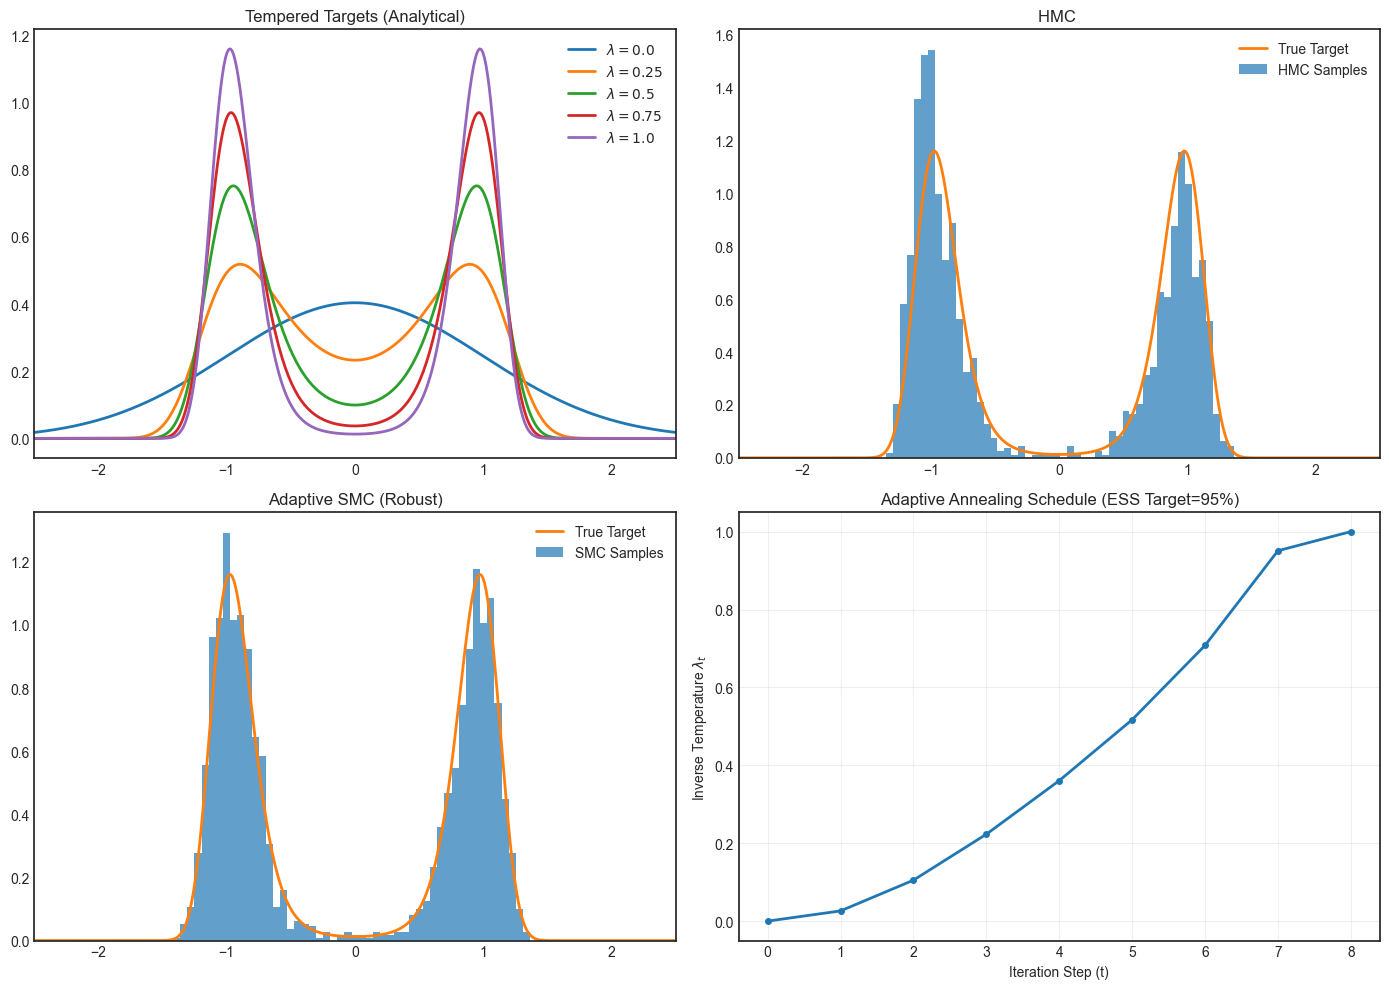

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# --- 1. Define Target & Energy ---
c_const = 5.0

def energy(theta):
    # E(theta) = c * (theta^2 - 1)^2
    return c_const * (theta**2 - 1)**2

def log_target(theta, lam):
    # log pi_t(theta) = log prior - lambda * Energy
    log_prior = norm.logpdf(theta, 0, 1)
    return log_prior - lam * energy(theta)

def log_target_grad(theta, lam):
    # Gradient for HMC
    # d/dtheta ( -0.5 theta^2 - lam * c(theta^2-1)^2 )
    # = -theta - lam * 4c * theta * (theta^2 - 1)
    d_energy = 4 * c_const * theta * (theta**2 - 1)
    return -theta - lam * d_energy

# --- 2. Standard HMC Implementation ---
def run_hmc(n_samples, epsilon=0.05, L=10, start_val=1.0):
    samples = np.zeros(n_samples)
    curr_q = start_val
    
    for i in range(n_samples):
        q = curr_q
        p = np.random.normal(0, 1)
        curr_p = p
        
        # Leapfrog
        grad = log_target_grad(q, 1.0)
        p = p + epsilon * grad / 2
        for _ in range(L):
            q = q + epsilon * p
            if _ != L - 1:
                p = p + epsilon * log_target_grad(q, 1.0)
        p = p + epsilon * log_target_grad(q, 1.0) / 2
        p = -p
        
        # Metropolis
        current_U = -log_target(curr_q, 1.0)
        current_K = curr_p**2 / 2
        proposed_U = -log_target(q, 1.0)
        proposed_K = p**2 / 2
        
        if np.random.rand() < np.exp(current_U - proposed_U + current_K - proposed_K):
            curr_q = q
        
        samples[i] = curr_q
    return samples

# --- 3. Adaptive SMC Implementation ---
def run_adaptive_smc(N=1000, ess_target_ratio=0.90):
    # Higher target ratio (0.90) forces smaller steps -> better annealing illustration
    particles = np.random.normal(0, 1, N)
    weights = np.ones(N) / N
    lam = 0.0
    
    lambdas = [0.0]
    # We'll store history for specific lambdas to plot "Tempered Targets" later
    history_plots = {0.0: particles.copy()}
    
    while lam < 1.0:
        energies = energy(particles)
        
        # Solve for delta such that ESS == ess_target
        def objective(delta):
            log_w = -delta * energies
            w = np.exp(log_w - np.max(log_w))
            w /= np.sum(w)
            ess = 1.0 / np.sum(w**2)
            return ess - (ess_target_ratio * N)

        max_delta = 1.0 - lam
        # Check if we can jump to 1.0
        if objective(max_delta) > 0:
            delta = max_delta
        else:
            try:
                delta = brentq(objective, 1e-9, 2.0)
                delta = min(delta, max_delta)
            except:
                delta = max_delta * 0.5 # Fallback

        lam += delta
        lambdas.append(lam)
        
        # Reweight
        log_w_inc = -delta * energies
        w_unnorm = np.exp(log_w_inc - np.max(log_w_inc))
        weights = w_unnorm / np.sum(w_unnorm)
        
        # Resample (Systematic)
        u = (np.arange(N) + np.random.uniform()) / N
        cumsum = np.cumsum(weights)
        indices = np.zeros(N, dtype=int)
        j = 0
        for i in range(N):
            while u[i] > cumsum[j]:
                j += 1
            indices[i] = j
        particles = particles[indices]
        weights = np.ones(N) / N
        
        # Move (MCMC Rejuvenation)
        prop_std = 0.5 # Tuning parameter
        for _ in range(3): 
            noise = np.random.normal(0, prop_std, N)
            props = particles + noise
            lp_curr = log_target(particles, lam)
            lp_prop = log_target(props, lam)
            ratio = lp_prop - lp_curr
            accept = np.log(np.random.rand(N)) < ratio
            particles[accept] = props[accept]
            
        # Store for plotting if close to quarters
        if len(history_plots) < 5:
            if (lam >= 0.25 and 0.25 not in history_plots): history_plots[0.25] = particles.copy()
            elif (lam >= 0.5 and 0.5 not in history_plots): history_plots[0.5] = particles.copy()
            elif (lam >= 0.75 and 0.75 not in history_plots): history_plots[0.75] = particles.copy()
            
    history_plots[1.0] = particles.copy()
    return history_plots, lambdas

# --- Run ---
np.random.seed(42)
# HMC
hmc_samples = run_hmc(2000, L=20,start_val=1.0) # Start at one mode

# SMC with strict annealing
smc_hist, lam_sched = run_adaptive_smc(N=2000, ess_target_ratio=0.95)

# --- Plotting ---
plt.figure(figsize=(14, 10))
x_grid = np.linspace(-2.5, 2.5, 400)
log_p_true = log_target(x_grid, 1.0)
p_true = np.exp(log_p_true) / np.trapz(np.exp(log_p_true), x_grid)

# 1. Tempered Distributions
ax1 = plt.subplot(2, 2, 1)
# Plot analytical curves for specific lambdas
plot_lams = [0.0, 0.25, 0.5, 0.75, 1.0]
for l in plot_lams:
    lp = log_target(x_grid, l)
    p = np.exp(lp)
    p /= np.trapz(p, x_grid)
    ax1.plot(x_grid, p, label=f"$\lambda={l}$", linewidth=2)
ax1.set_title("Tempered Targets (Analytical)")
ax1.legend()
ax1.set_xlim(-2.5, 2.5)

# 2. HMC
ax2 = plt.subplot(2, 2, 2)
ax2.plot(x_grid, p_true, 'tab:orange', linewidth=2, label='True Target')
ax2.hist(hmc_samples, bins=50, density=True, alpha=0.7, label='HMC Samples')
ax2.set_title("HMC ")
ax2.legend()
ax2.set_xlim(-2.5, 2.5)

# 3. SMC
ax3 = plt.subplot(2, 2, 3)
ax3.plot(x_grid, p_true, 'tab:orange', linewidth=2, label='True Target')
ax3.hist(smc_hist[1.0], bins=50, density=True, alpha=0.7, label='SMC Samples')
ax3.set_title("Adaptive SMC (Robust)")
ax3.legend()
ax3.set_xlim(-2.5, 2.5)

# 4. Schedule
ax4 = plt.subplot(2, 2, 4)
ax4.plot(lam_sched, marker='o', markersize=4)
ax4.set_xlabel("Iteration Step (t)")
ax4.set_ylabel("Inverse Temperature $\lambda_t$")
ax4.set_title("Adaptive Annealing Schedule (ESS Target=95%)")
ax4.grid(True, alpha=0.3)
# Highlight the 'slow' middle phase
#ax4.text(len(lam_sched)/4, 0.5, "Slower steps to\ncross barrier", color='red', alpha=0.6)

plt.tight_layout()
plt.show()

# 9. SMC Sampler: Widely Separated Modes (Geometric Path)
**Reference:** Book Ch 13.6.2

We now consider a much harder problem: a target distribution with two **widely separated modes** (at -5 and 5) separated by a region of negligible probability.

### The Challenge
Standard HMC will get stuck in one mode forever because the gradient in the middle (at 0) is effectively zero, and the probability mass there is vanishingly small. The "tunnel" is too long to cross.

### The Solution: Geometric Path Tempering
Instead of defining an arbitrary energy function, we simply interpolate between a broad **Prior** (easy to sample) and the **Target** using a geometric path:
$$\pi_t(\theta) \propto \pi_{\text{prior}}(\theta)^{1-\lambda_t} \pi_{\text{target}}(\theta)^{\lambda_t}$$
* **$\lambda=0$:** We sample from the wide Prior.
* **$\lambda=1$:** We sample from the separated Target.

SMC smoothly morphs the broad distribution into the two sharp peaks, ensuring particles populate both modes before they become separated.

C:\Users\ICMAT User\AppData\Local\Temp\ipykernel_33448\1507242355.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples[i] = curr_q
C:\Users\ICMAT User\AppData\Local\Temp\ipykernel_33448\1507242355.py:179: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p /= np.trapz(p, x_grid)


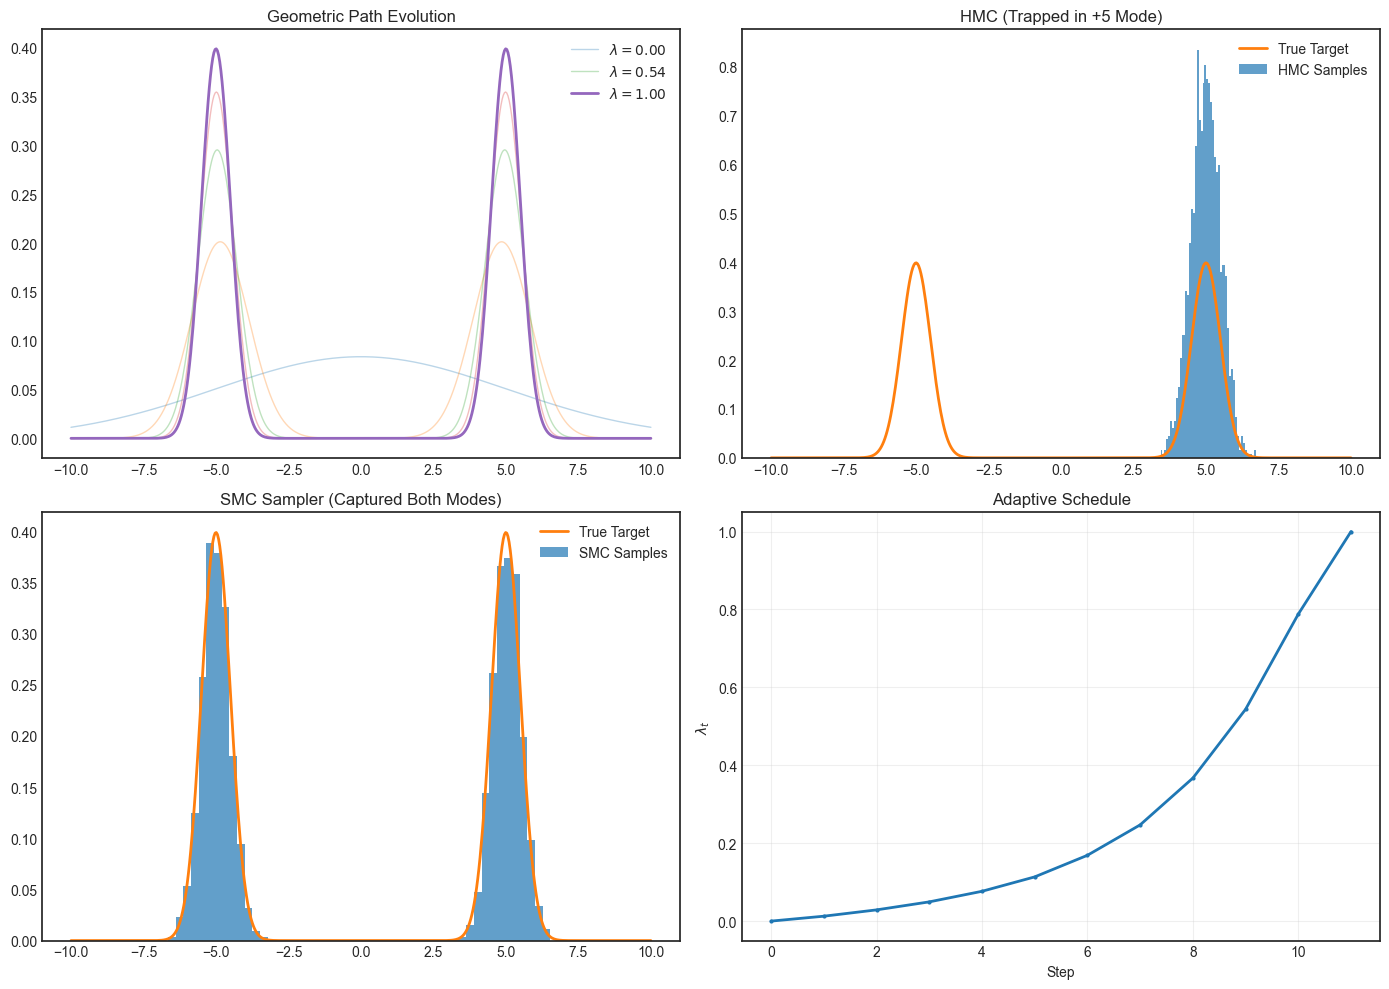

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.special import logsumexp

# --- 1. Define Distributions ---
# Target: Mixture of N(-5, 0.5) and N(5, 0.5)
mu1, mu2 = -5.0, 5.0
sig_target = 0.5
prior_std = 5.0

def log_prior_pdf(theta):
    return norm.logpdf(theta, loc=0, scale=prior_std)

def log_target_pdf(theta):
    # Log PDF of 0.5*N(mu1, sig) + 0.5*N(mu2, sig)
    # Using log-sum-exp for stability
    lp1 = norm.logpdf(theta, loc=mu1, scale=sig_target) + np.log(0.5)
    lp2 = norm.logpdf(theta, loc=mu2, scale=sig_target) + np.log(0.5)
    # Stack along a new axis to perform logsumexp
    return logsumexp(np.vstack([lp1, lp2]), axis=0)

def log_tempered_target(theta, lam):
    # Geometric path: pi_t ~ Prior^(1-lam) * Target^lam
    # log pi_t = (1-lam)*log_prior + lam*log_target
    return (1.0 - lam) * log_prior_pdf(theta) + lam * log_target_pdf(theta)

def log_tempered_grad(theta, lam):
    # Gradient of the geometric path
    # grad = (1-lam)*grad_prior + lam*grad_target
    
    # Grad Prior: -theta / sigma^2
    grad_prior = -theta / (prior_std**2)
    
    # Grad Target (GMM):
    # grad_log_p = (1/p) * sum( w_k * p_k * grad_log_p_k )
    # grad_log_N(mu, sig) = -(theta - mu)/sig^2
    
    # We compute weights responsibilities: r_k = w_k * p_k / p
    lp1 = norm.logpdf(theta, loc=mu1, scale=sig_target) + np.log(0.5)
    lp2 = norm.logpdf(theta, loc=mu2, scale=sig_target) + np.log(0.5)
    log_p = logsumexp(np.vstack([lp1, lp2]), axis=0)
    
    resp1 = np.exp(lp1 - log_p)
    resp2 = np.exp(lp2 - log_p)
    
    grad_gmm1 = -(theta - mu1) / (sig_target**2)
    grad_gmm2 = -(theta - mu2) / (sig_target**2)
    
    grad_target = resp1 * grad_gmm1 + resp2 * grad_gmm2
    
    return (1.0 - lam) * grad_prior + lam * grad_target

# --- 2. HMC Implementation ---
def run_hmc(n_samples, epsilon=0.1, L=20, start_val=mu2):
    samples = np.zeros(n_samples)
    curr_q = start_val
    
    for i in range(n_samples):
        q = curr_q
        p = np.random.normal(0, 1)
        curr_p = p
        
        # Leapfrog
        grad = log_tempered_grad(q, 1.0)
        p = p + epsilon * grad / 2
        for _ in range(L):
            q = q + epsilon * p
            if _ != L - 1:
                p = p + epsilon * log_tempered_grad(q, 1.0)
        p = p + epsilon * log_tempered_grad(q, 1.0) / 2
        p = -p
        
        current_U = -log_tempered_target(curr_q, 1.0)
        current_K = curr_p**2 / 2
        proposed_U = -log_tempered_target(q, 1.0)
        proposed_K = p**2 / 2
        
        if np.random.rand() < np.exp(current_U - proposed_U + current_K - proposed_K):
            curr_q = q
        samples[i] = curr_q
    return samples

# --- 3. Adaptive SMC Implementation ---
def run_adaptive_smc_geometric(N=1000, ess_target_ratio=0.90):
    particles = np.random.normal(0, prior_std, N) # Start from Prior
    weights = np.ones(N) / N
    lam = 0.0
    lambdas = [0.0]
    
    # Track evolution
    history_plots = {0.0: particles.copy()}
    
    while lam < 1.0:
        # Calculate Log Likelihood Ratio for weights
        # log_w_incremental = (lambda_new - lambda_old) * (log_target - log_prior)
        # Note: This comes from the definition of geometric path weights
        log_prior_val = log_prior_pdf(particles)
        log_target_val = log_target_pdf(particles)
        log_ratio = log_target_val - log_prior_val
        
        # Solve for delta
        def objective(delta):
            log_w = delta * log_ratio
            w = np.exp(log_w - np.max(log_w))
            w /= np.sum(w)
            ess = 1.0 / np.sum(w**2)
            return ess - (ess_target_ratio * N)

        max_delta = 1.0 - lam
        if objective(max_delta) > 0:
            delta = max_delta
        else:
            try:
                delta = brentq(objective, 1e-9, 1.0) # Larger search range
                delta = min(delta, max_delta)
            except:
                delta = max_delta * 0.1 # Fallback

        lam += delta
        lambdas.append(lam)
        
        # Reweight
        log_w_inc = delta * log_ratio
        w_unnorm = np.exp(log_w_inc - np.max(log_w_inc))
        weights = w_unnorm / np.sum(w_unnorm)
        
        # Resample
        u = (np.arange(N) + np.random.uniform()) / N
        cumsum = np.cumsum(weights)
        indices = np.zeros(N, dtype=int)
        j = 0
        for i in range(N):
            while u[i] > cumsum[j]:
                j += 1
            indices[i] = j
        particles = particles[indices]
        weights = np.ones(N) / N
        
        # Move (MCMC)
        prop_std = 0.5 
        for _ in range(5): 
            noise = np.random.normal(0, prop_std, N)
            props = particles + noise
            lp_curr = log_tempered_target(particles, lam)
            lp_prop = log_tempered_target(props, lam)
            ratio = lp_prop - lp_curr
            accept = np.log(np.random.rand(N)) < ratio
            particles[accept] = props[accept]
            
        # Store snapshots
        if len(history_plots) < 6:
            # Capture roughly quarter points
            last_key = list(history_plots.keys())[-1]
            if (lam - last_key) > 0.2: 
                 history_plots[lam] = particles.copy()
            
    history_plots[1.0] = particles.copy()
    return history_plots, lambdas

# --- Run ---
np.random.seed(99)
hmc_samples = run_hmc(2000, start_val=mu2) # Start at +5
smc_hist, lam_sched = run_adaptive_smc_geometric(N=2000, ess_target_ratio=0.95)

# --- Plotting ---
plt.figure(figsize=(14, 10))
x_grid = np.linspace(-10, 10, 500)
p_true = np.exp(log_target_pdf(x_grid))

# 1. Target Evolution
ax1 = plt.subplot(2, 2, 1)
# Plot analytical path
keys = sorted(list(smc_hist.keys()))
for k in keys:
    lp = log_tempered_target(x_grid, k)
    p = np.exp(lp)
    p /= np.trapz(p, x_grid)
    alpha = 0.3 if k < 1.0 else 1.0
    width = 1 if k < 1.0 else 2
    label = f"$\lambda={k:.2f}$" if (k==0 or k==1 or k==keys[len(keys)//2]) else None
    ax1.plot(x_grid, p, label=label, alpha=alpha, linewidth=width)
ax1.set_title("Geometric Path Evolution")
ax1.legend()

# 2. HMC Failure
ax2 = plt.subplot(2, 2, 2)
ax2.plot(x_grid, p_true, 'tab:orange', label='True Target')
ax2.hist(hmc_samples, bins=50, density=True, alpha=0.7, label='HMC Samples')
ax2.set_title("HMC (Trapped in +5 Mode)")
ax2.legend()

# 3. SMC Success
ax3 = plt.subplot(2, 2, 3)
ax3.plot(x_grid, p_true, 'tab:orange', label='True Target')
ax3.hist(smc_hist[1.0], bins=50, density=True, alpha=0.7, label='SMC Samples')
ax3.set_title("SMC Sampler (Captured Both Modes)")
ax3.legend()

# 4. Schedule
ax4 = plt.subplot(2, 2, 4)
ax4.plot(lam_sched, marker='.', markersize=4)
ax4.set_xlabel("Step")
ax4.set_ylabel("$\lambda_t$")
ax4.set_title("Adaptive Schedule")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 10. Performance Comparison: Adaptive IBIS vs. Full SMC (Long Run)
**Reference:** Book Ch 13.6.3

We perform a single, extended experiment to compare **Adaptive IBIS** against **Full SMC** (Always Resample).

### Experimental Setup
* **Data:** A sequence of $T=200$ observations from $\mathcal{N}(\mu=3.14, \sigma=1)$.
* **Goal:** Observe the convergence of the posterior $\mu$ and measure the computational cost.

### Visualizations
1.  **Posterior Evolution (Top Row):** We plot the posterior for $\mu$ at $t=1$, $t=50$, and $t=200$.
    * **t=1:** Both methods start with a wide uncertainty (influenced by the prior).
    * **t=200:** Both methods converge tightly around the true mean (vertical black line).
2.  **Efficiency (Bottom Row):**
    * **ESS Trace:** Shows how IBIS allows the effective sample size to decay naturally, resampling only when necessary (the "sawtooth" pattern is less frequent). Full SMC resamples constantly.
    * **Execution Time:** The bar chart highlights the massive speed difference. Since MCMC moves take $O(t)$ time (scanning all history), doing them at every step makes Full SMC prohibitively slow for long sequences.

Running Adaptive IBIS...
Running Full SMC (Always Resample)...


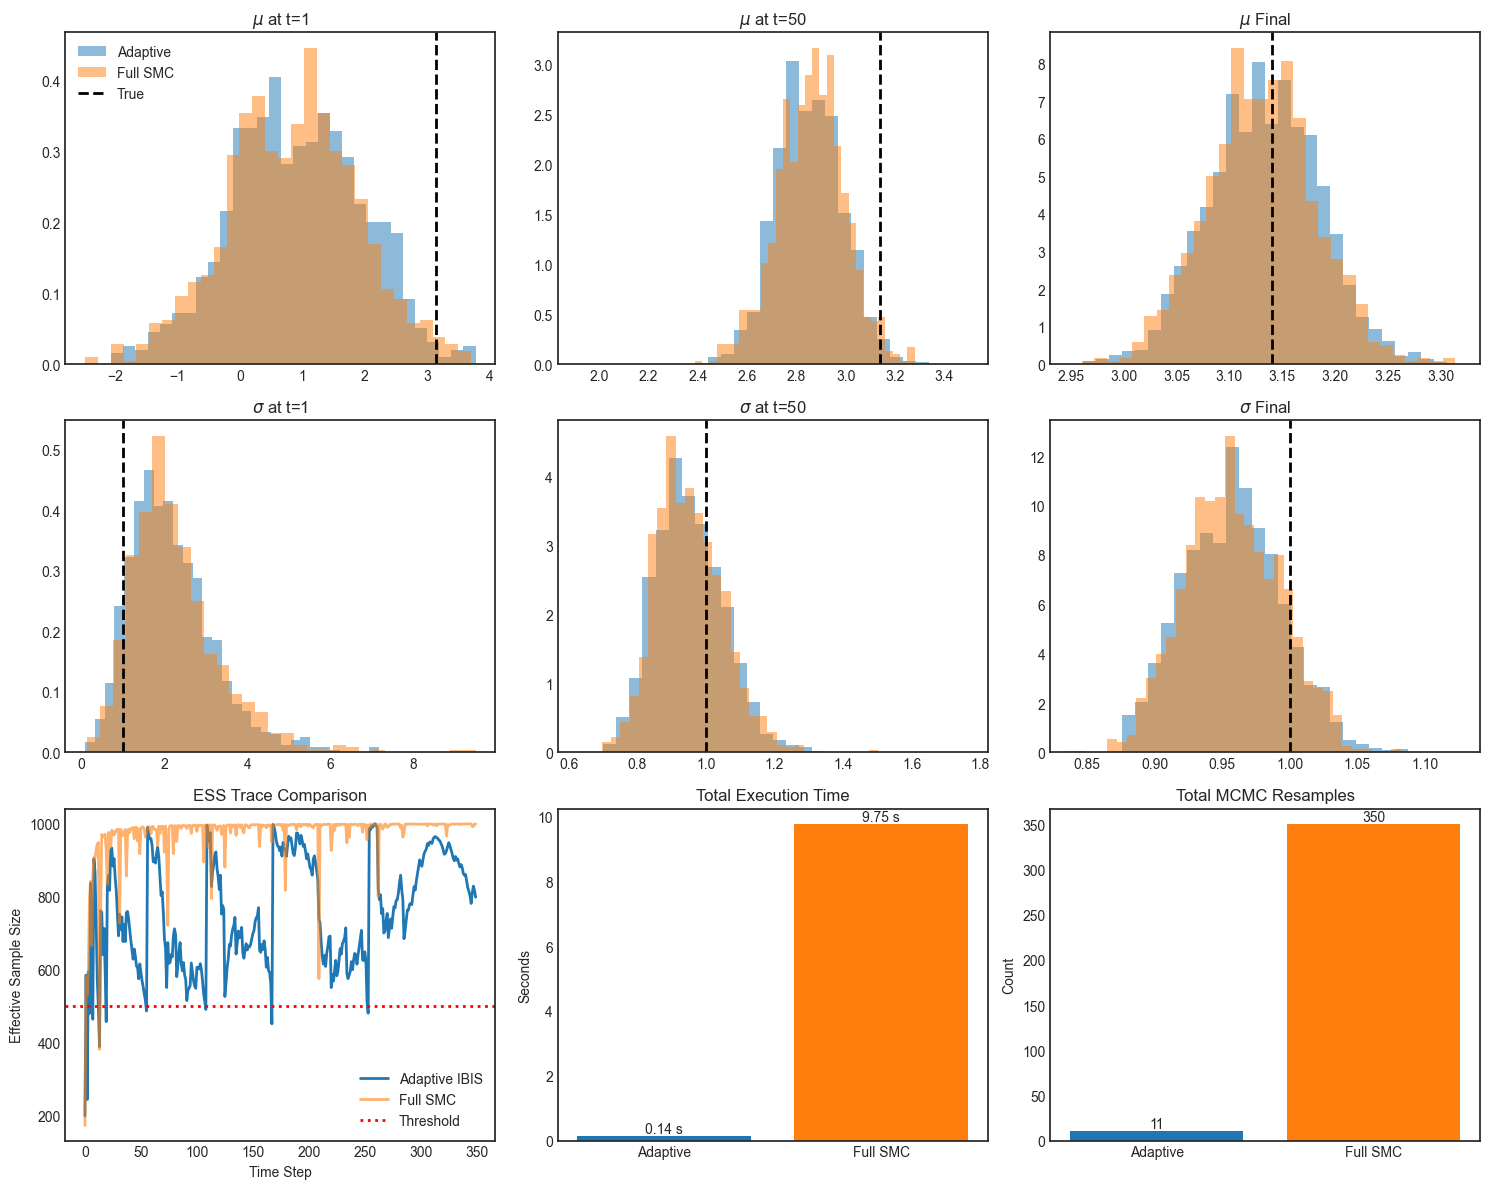

In [62]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

# --- Parameters ---
true_mu = 3.14
true_sigma = 1.0
T_data = 350      # Long run
N_particles = 1000
ess_threshold = 500

# Generate Data
np.random.seed(42)
data = np.random.normal(true_mu, true_sigma, T_data)

# --- Generalized IBIS Function ---
def run_ibis_benchmark(y_seq, N=1000, force_resample=False):
    start_time = time.time()
    
    parts_mu = np.random.normal(0, 1, N)
    parts_sig = np.random.gamma(1, 1, N)
    weights = np.ones(N) / N
    ess_history = []
    
    mcmc_count = 0
    
    # Store snapshots at t=0 (1st obs), t=49 (50th obs), and final
    snapshots = {}
    
    for t in range(len(y_seq)):
        y_new = y_seq[t]
        
        # 1. Reweight
        log_lik = norm.logpdf(y_new, loc=parts_mu, scale=parts_sig)
        log_w = np.log(weights + 1e-300) + log_lik
        w_unnorm = np.exp(log_w - np.max(log_w))
        weights = w_unnorm / np.sum(w_unnorm)
        
        # 2. ESS Check
        ess = 1.0 / np.sum(weights**2)
        ess_history.append(ess)
        
        # 3. Resample Logic
        if force_resample or (ess < ess_threshold):
            mcmc_count += 1
            
            # Resample
            u = (np.arange(N) + np.random.uniform()) / N
            cumsum = np.cumsum(weights)
            indices = np.zeros(N, dtype=int)
            j = 0
            for i in range(N):
                while u[i] > cumsum[j]:
                    j += 1
                indices[i] = j
            parts_mu = parts_mu[indices]
            parts_sig = parts_sig[indices]
            weights = np.ones(N) / N
            
            # Move (MCMC)
            current_data = y_seq[:t+1]
            prop_std_mu = np.std(parts_mu)
            prop_std_sig = np.std(parts_sig)
            
            for _ in range(3): 
                prop_mu = parts_mu + np.random.normal(0, prop_std_mu, N)
                prop_sig = np.abs(parts_sig + np.random.normal(0, prop_std_sig, N))
                
                lp_curr = norm.logpdf(parts_mu, 0, 1) + gamma.logpdf(parts_sig, 1)
                lp_prop = norm.logpdf(prop_mu, 0, 1) + gamma.logpdf(prop_sig, 1)
                
                ll_curr = np.sum(norm.logpdf(current_data[:, None], parts_mu, parts_sig), axis=0)
                ll_prop = np.sum(norm.logpdf(current_data[:, None], prop_mu, prop_sig), axis=0)
                
                ratio = (lp_prop + ll_prop) - (lp_curr + ll_curr)
                accept = np.log(np.random.rand(N)) < ratio
                
                parts_mu[accept] = prop_mu[accept]
                parts_sig[accept] = prop_sig[accept]
                
        # Save snapshots
        if t == 0: 
            snapshots['t1'] = (parts_mu.copy(), parts_sig.copy(), weights.copy())
        if t == 49: 
            snapshots['t50'] = (parts_mu.copy(), parts_sig.copy(), weights.copy())
        if t == len(y_seq) - 1: 
            snapshots['tend'] = (parts_mu.copy(), parts_sig.copy(), weights.copy())
                
    total_time = time.time() - start_time
    return ess_history, snapshots, total_time, mcmc_count

# --- Run Benchmark ---
print("Running Adaptive IBIS...")
ess_adapt, snap_adapt, time_adapt, moves_adapt = run_ibis_benchmark(data, N_particles, force_resample=False)

print("Running Full SMC (Always Resample)...")
ess_full, snap_full, time_full, moves_full = run_ibis_benchmark(data, N_particles, force_resample=True)

# --- Plotting ---
fig = plt.figure(figsize=(15, 12))

# Helper
def plot_snap(ax, s_adapt, s_full, param_idx, true_val, title, show_legend=False):
    # param_idx: 0 for mu, 1 for sigma
    d1, _, w1 = s_adapt[param_idx], s_adapt[1], s_adapt[2] # Extract Correct Param
    if param_idx == 1: d1 = s_adapt[1] # Fix extraction for sigma
    
    d2, _, w2 = s_full[param_idx], s_full[1], s_full[2]
    if param_idx == 1: d2 = s_full[1]

    ax.hist(d1, weights=w1, bins=30, alpha=0.5, label='Adaptive', density=True)
    ax.hist(d2, weights=w2, bins=30, alpha=0.5, label='Full SMC', density=True)
    ax.axvline(true_val, color='k', linestyle='--', label='True')
    ax.set_title(title)
    if show_legend: ax.legend()

# Row 1: Mu Evolution
ax1 = plt.subplot(3, 3, 1)
plot_snap(ax1, snap_adapt['t1'], snap_full['t1'], 0, true_mu, "$\mu$ at t=1", True)
ax2 = plt.subplot(3, 3, 2)
plot_snap(ax2, snap_adapt['t50'], snap_full['t50'], 0, true_mu, "$\mu$ at t=50")
ax3 = plt.subplot(3, 3, 3)
plot_snap(ax3, snap_adapt['tend'], snap_full['tend'], 0, true_mu, "$\mu$ Final")

# Row 2: Sigma Evolution
ax4 = plt.subplot(3, 3, 4)
plot_snap(ax4, snap_adapt['t1'], snap_full['t1'], 1, true_sigma, "$\sigma$ at t=1")
ax5 = plt.subplot(3, 3, 5)
plot_snap(ax5, snap_adapt['t50'], snap_full['t50'], 1, true_sigma, "$\sigma$ at t=50")
ax6 = plt.subplot(3, 3, 6)
plot_snap(ax6, snap_adapt['tend'], snap_full['tend'], 1, true_sigma, "$\sigma$ Final")

# Row 3: Efficiency & ESS
# ESS Trace (NEW)
ax7 = plt.subplot(3, 3, 7)
ax7.plot(ess_adapt, label='Adaptive IBIS')
ax7.plot(ess_full, label='Full SMC', alpha=0.6)
ax7.axhline(500, color='r', linestyle=':', label='Threshold')
ax7.set_title("ESS Trace Comparison")
ax7.set_xlabel("Time Step")
ax7.set_ylabel("Effective Sample Size")
ax7.legend()

# Execution Time
ax8 = plt.subplot(3, 3, 8)
bars = ax8.bar(['Adaptive', 'Full SMC'], [time_adapt, time_full], color=['tab:blue', 'tab:orange'])
ax8.set_ylabel("Seconds")
ax8.set_title("Total Execution Time")
ax8.bar_label(bars, fmt='%.2f s')

# MCMC Moves
ax9 = plt.subplot(3, 3, 9)
bars2 = ax9.bar(['Adaptive', 'Full SMC'], [moves_adapt, moves_full], color=['tab:blue', 'tab:orange'])
ax9.set_ylabel("Count")
ax9.set_title("Total MCMC Resamples")
ax9.bar_label(bars2)

plt.tight_layout()
plt.show()

# 13. SMC-ABC: Lotka-Volterra (Predator-Prey)
**Reference:** Book Ch 13.6.5

**Likelihood-Free Inference (SMC-ABC)** is essential when we have a complex simulator where we cannot evaluate the likelihood $p(y|\theta)$, but we can generate data $y \sim p(\cdot|\theta)$.



### The Model: Predator-Prey Dynamics
We infer the parameters of the classic Lotka-Volterra system, which describes the interaction between a Prey population ($u$) and a Predator population ($v$):
$$
\begin{aligned}
\frac{du}{dt} &= \alpha u - \beta u v \quad \text{(Prey growth vs. predation)} \\
\frac{dv}{dt} &= -\gamma v + \delta u v \quad \text{(Predator death vs. reproduction)}
\end{aligned}
$$

**True Parameters for this Experiment:**
We attempt to recover the following ground truth values from noisy data:
* $\alpha = 1.1$ (Prey Growth Rate)
* $\beta = 0.4$ (Predation Rate)
* $\gamma = 0.4$ (Predator Death Rate)
* $\delta = 0.1$ (Interaction/Reproduction Rate)

### The Algorithm: Adaptive SMC-ABC
Instead of a single rejection step (standard ABC), which has high rejection rates for small $\epsilon$, we use **Sequential Monte Carlo**:
1.  **Initialize:** Sample $\theta$ from the Prior.
2.  **Adaptive Threshold:** At each step $t$, set the tolerance $\epsilon_t$ to the median distance of the current population. This ensures a steady acceptance rate.
3.  **Reweight & Resample:** Keep particles where $d(y_{sim}, y_{obs}) < \epsilon_t$.
4.  **Move (Perturb):** Apply an MCMC kernel to rejuvenate the particles, accepting only if the new parameters generate a trajectory within the distance threshold $\epsilon_t$.

Running High-Precision SMC-ABC...
Gen 0: epsilon (Log-RMSE) = 3.4020
Gen 1: epsilon (Log-RMSE) = 2.0082
Gen 2: epsilon (Log-RMSE) = 1.5553
Gen 3: epsilon (Log-RMSE) = 1.3567
Gen 4: epsilon (Log-RMSE) = 1.2693
Gen 5: epsilon (Log-RMSE) = 1.1908
Gen 6: epsilon (Log-RMSE) = 1.1323
Gen 7: epsilon (Log-RMSE) = 1.0703
Gen 8: epsilon (Log-RMSE) = 0.8973
Gen 9: epsilon (Log-RMSE) = 0.7188
Gen 10: epsilon (Log-RMSE) = 0.6222
Gen 11: epsilon (Log-RMSE) = 0.5353
Gen 12: epsilon (Log-RMSE) = 0.4552
Gen 13: epsilon (Log-RMSE) = 0.3958
Gen 14: epsilon (Log-RMSE) = 0.3449
Gen 15: epsilon (Log-RMSE) = 0.3045
Gen 16: epsilon (Log-RMSE) = 0.2768
Gen 17: epsilon (Log-RMSE) = 0.2545
Gen 18: epsilon (Log-RMSE) = 0.2403
Gen 19: epsilon (Log-RMSE) = 0.2301


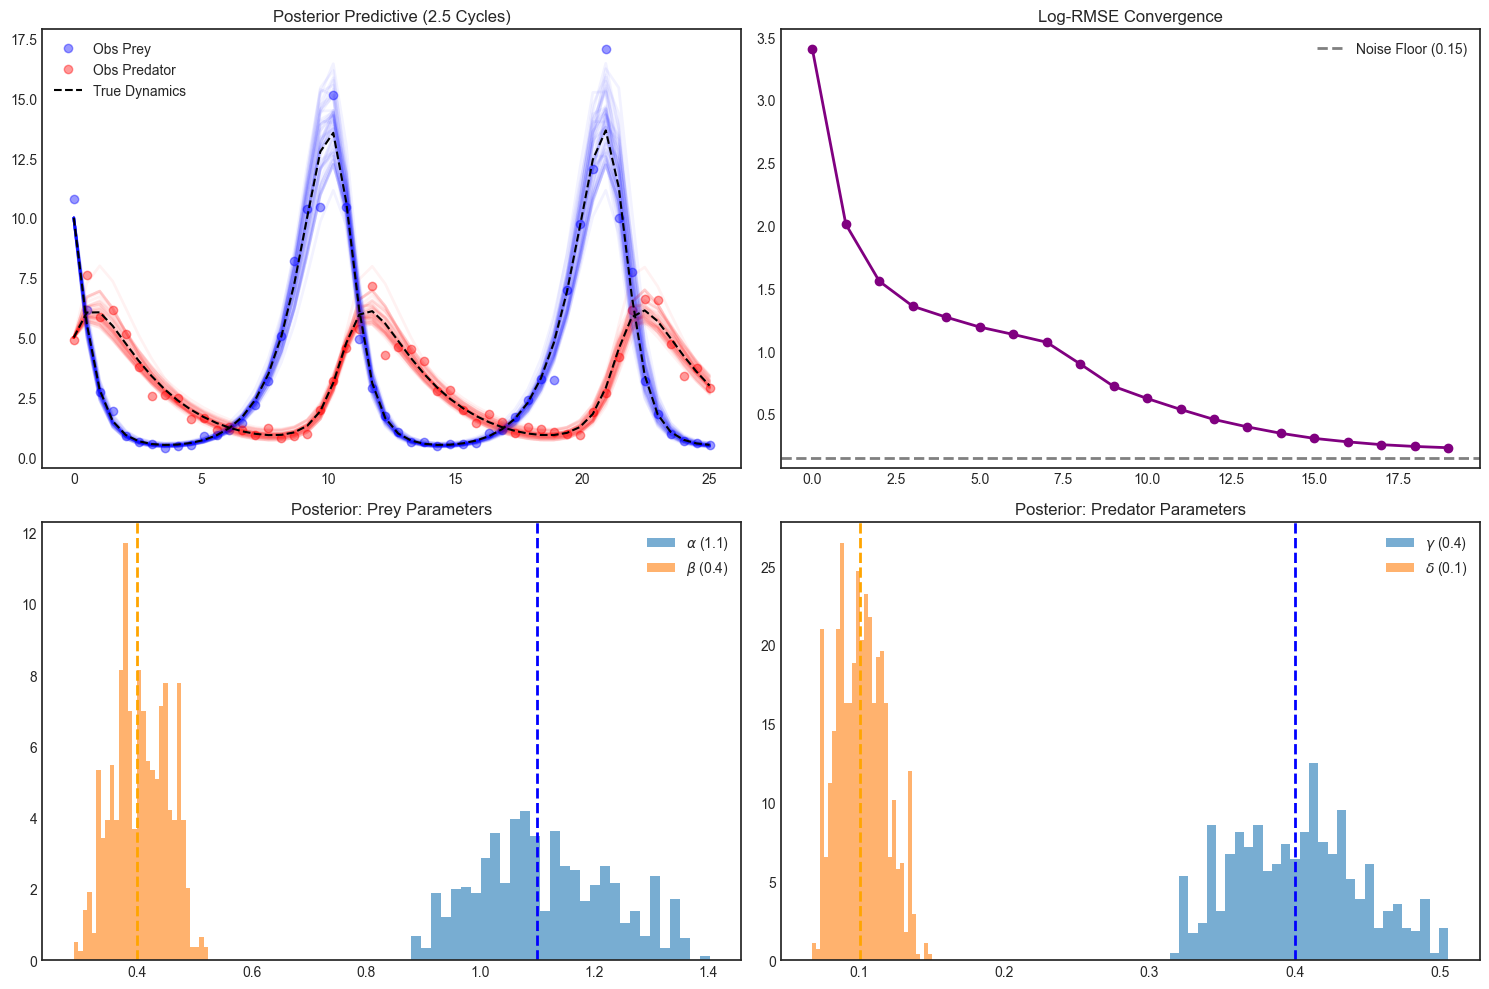

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# --- 1. The Simulator ---
def lotka_volterra(state, t, alpha, beta, gamma, delta):
    u, v = state
    # Clamp to prevent numerical issues
    u = max(u, 0)
    v = max(v, 0)
    du_dt = alpha * u - beta * u * v
    dv_dt = -gamma * v + delta * u * v
    return [du_dt, dv_dt]

def simulator(theta, t_points):
    X0 = [10.0, 5.0] 
    try:
        solution = odeint(lotka_volterra, X0, t_points, args=tuple(theta))
    except:
        return np.ones((len(t_points), 2)) * 1e6
    
    # Add Log-Normal Noise (sigma = 0.15 for clearer signal)
    noise = np.random.lognormal(mean=0, sigma=0.15, size=solution.shape)
    return solution * noise

# --- KEY FIX: Log-Space Distance ---
def calc_log_distance(y_sim, y_obs):
    # Avoid log(0) by adding tiny constant
    log_sim = np.log(y_sim + 1e-6)
    log_obs = np.log(y_obs + 1e-6)
    # RMSE in Log Space matches the Log-Normal noise assumption
    return np.sqrt(np.mean((log_sim - log_obs)**2))

# --- 2. Setup Ground Truth (Longer Duration) ---
np.random.seed(42)
true_theta = [1.1, 0.4, 0.4, 0.1]
# Extended time to capture 2+ full cycles
t_obs = np.linspace(0, 25, 50) 

# Generate Data
y_clean = odeint(lotka_volterra, [10.0, 5.0], t_obs, args=tuple(true_theta))
y_obs = y_clean * np.random.lognormal(0, 0.15, size=y_clean.shape)

# Prior
prior_min = np.array([0.1, 0.1, 0.1, 0.01]) # Tightened priors slightly for speed
prior_max = np.array([2, 1.5, 1.5, 0.6])

def prior_log_pdf(theta):
    if np.any(theta < prior_min) or np.any(theta > prior_max):
        return -np.inf
    return 0.0

# --- 3. SMC-ABC Algorithm ---
def run_smc_abc_converged(y_target, t_points, N=1000, max_steps=20):
    particles = np.random.uniform(prior_min, prior_max, (N, 4))
    distances = np.zeros(N)
    
    for i in range(N):
        y_sim = simulator(particles[i], t_points)
        distances[i] = calc_log_distance(y_sim, y_target) # Use Log Dist
        
    epsilons = []
    
    for t in range(max_steps):
        current_eps = np.median(distances)
        epsilons.append(current_eps)
        print(f"Gen {t}: epsilon (Log-RMSE) = {current_eps:.4f}")
        
        # Stricter stopping condition
        if current_eps < 0.15: # Close to noise floor sigma=0.15
            print("Converged to noise floor.")
            break
            
        survivors_mask = distances <= current_eps
        survivors = particles[survivors_mask]
        
        if len(survivors) < 5: break
            
        indices = np.random.choice(len(survivors), N, replace=True)
        particles = survivors[indices]
        
        cov = np.cov(survivors.T) + 1e-6 * np.eye(4)
        distances = np.zeros(N)
        
        for i in range(N):
            curr_theta = particles[i]
            prop = curr_theta + np.random.multivariate_normal(np.zeros(4), cov)
            
            if prior_log_pdf(prop) == 0.0:
                y_sim_prop = simulator(prop, t_points)
                d_prop = calc_log_distance(y_sim_prop, y_target)
                
                if d_prop <= current_eps:
                    particles[i] = prop
                    distances[i] = d_prop
                else:
                    y_sim_curr = simulator(curr_theta, t_points)
                    distances[i] = calc_log_distance(y_sim_curr, y_target)
            else:
                y_sim_curr = simulator(curr_theta, t_points)
                distances[i] = calc_log_distance(y_sim_curr, y_target)
                
    return particles, epsilons

# --- Run ---
print("Running High-Precision SMC-ABC...")
final_thetas, eps_sched = run_smc_abc_converged(y_obs, t_obs, N=1000, max_steps=20)

# --- Plotting ---
fig = plt.figure(figsize=(15, 10))

# 1. Trajectory
ax1 = plt.subplot(2, 2, 1)
ax1.plot(t_obs, y_obs[:, 0], 'bo', alpha=0.4, label='Obs Prey')
ax1.plot(t_obs, y_obs[:, 1], 'ro', alpha=0.4, label='Obs Predator')
# Plot posterior samples
for i in range(0, len(final_thetas), 20):
    sim = odeint(lotka_volterra, [10.0, 5.0], t_obs, args=tuple(final_thetas[i]))
    ax1.plot(t_obs, sim[:, 0], 'b-', alpha=0.05)
    ax1.plot(t_obs, sim[:, 1], 'r-', alpha=0.05)
ax1.plot(t_obs, y_clean[:, 0], 'k--', linewidth=1.5, label='True Dynamics')
ax1.plot(t_obs, y_clean[:, 1], 'k--', linewidth=1.5)
ax1.set_title("Posterior Predictive (2.5 Cycles)")
ax1.legend()

# 2. Epsilon
ax2 = plt.subplot(2, 2, 2)
ax2.plot(eps_sched, 'o-', color='purple')
ax2.axhline(0.15, color='gray', linestyle='--', label='Noise Floor (0.15)')
ax2.set_title("Log-RMSE Convergence")
ax2.legend()

# 3. Parameters Alpha/Beta
ax3 = plt.subplot(2, 2, 3)
ax3.hist(final_thetas[:, 0], bins=30, alpha=0.6, label=r'$\alpha$ (1.1)', density=True)
ax3.hist(final_thetas[:, 1], bins=30, alpha=0.6, label=r'$\beta$ (0.4)', density=True)
ax3.axvline(true_theta[0], color='blue', linestyle='--', linewidth=2)
ax3.axvline(true_theta[1], color='orange', linestyle='--', linewidth=2)
ax3.set_title("Posterior: Prey Parameters")
ax3.legend()

# 4. Parameters Gamma/Delta
ax4 = plt.subplot(2, 2, 4)
ax4.hist(final_thetas[:, 2], bins=30, alpha=0.6, label=r'$\gamma$ (0.4)', density=True)
ax4.hist(final_thetas[:, 3], bins=30, alpha=0.6, label=r'$\delta$ (0.1)', density=True)
ax4.axvline(true_theta[2], color='blue', linestyle='--', linewidth=2)
ax4.axvline(true_theta[3], color='orange', linestyle='--', linewidth=2)
ax4.set_title("Posterior: Predator Parameters")
ax4.legend()

plt.tight_layout()
plt.show()